# Multinomial logistic regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(4)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [2]:
from numpy.linalg import inv

## Useful utility functions

In [3]:
def one_hot_encode(labels):
    '''
    Convert label indices into one-hot vectors
    
    Args:
        labels: n-element array with label indices.
    
    Returns:
        n times k matrix where each row is a one-hot encoding
        of a class label. k - number of classes.
    '''
    one_hot = np.zeros(shape = (labels.shape[0], np.max(labels) + 1))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    
    return one_hot.astype(np.float32)

In [4]:
def draw_params(ax, W):
    '''
    Draw parameters of a multinomial logistic regression in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        W:     Parameters of a multinomial logistic regression model.
               Shape (d+1) times k, where k is the number of classes and
               d is the number of explanatory variables.
    '''
    F = np.reshape(W[:-1, :].T, newshape=(2, -1, 28, 28))
    tiles(ax, F)


def tiles(ax, M):
    '''
    Draw volume M in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        M:     Volume to plot. Shape: r times c times h times w, where
               r is the number of rows in the output plot,
               c is the number of columns in the output plot,
               h is the height of a single tile,
               w is the width of a single tile.
    '''
    rows_count = M.shape[0]
    cols_count = M.shape[1]
    tile_height = M.shape[2]
    tile_width = M.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(M[r, c])
            ex_max = np.max(M[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (M[r, c] - ex_min) / (ex_max - ex_min)
    
    ax.matshow(img_matrix, cmap='gray', interpolation='none')
    ax.axis('off')

## MNIST dataset

In this lab we will use [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/). Lets import and prepare this dataset.

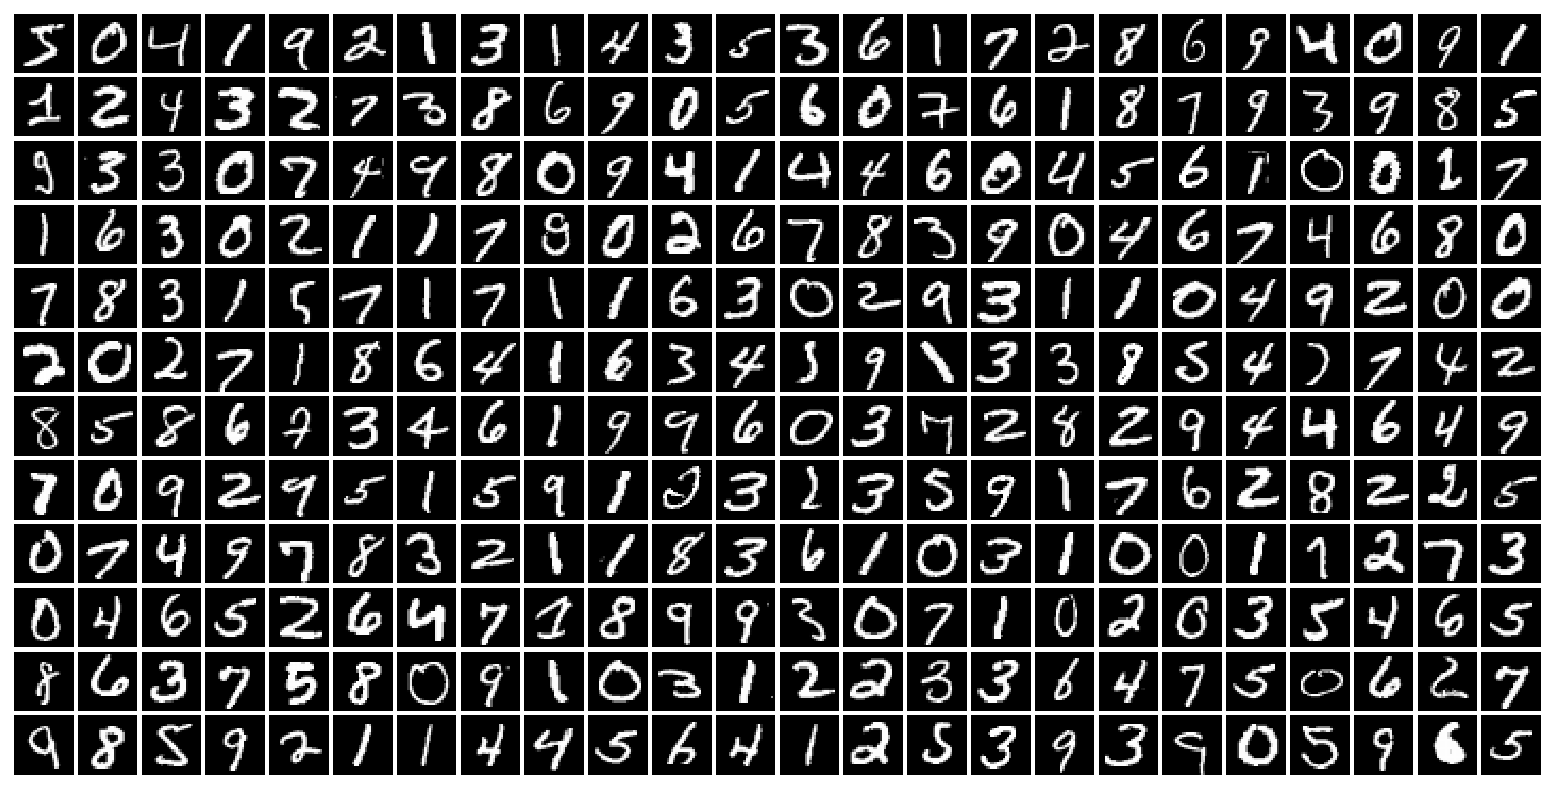

In [5]:
import mnist

fig = plt.figure(figsize=(14, 7))
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(plt.gca(), digits)

We will reshape each $28 \times 28$ pixel image into a $1 \times 784$ vector and append a fixed $1$ at the end. We will also convert images from $255$ from 255255 gray levels to $\langle 0, 1 \rangle$ interval. Finally, we will pick a random subset of 20,000 examples for training. The test part of the MNIST dataset will be used for validation.

In [6]:
##### Train set #####

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_train_images.shape[0], 1))
mnist_train_images = np.concatenate((mnist_train_images, ones), axis=1)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Validation set #####

mnist_val_images = mnist.test_images().astype(np.float32) / 255.0
mnist_val_images = np.reshape(mnist_val_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_val_images.shape[0], 1))
mnist_val_images = np.concatenate((mnist_val_images, ones), axis=1)

mnist_val_labels = mnist.test_labels()
mnist_val_labels = one_hot_encode(mnist_val_labels)

## Multinomial logistic regression model

Our goal is to fit a multinomial logistic regression model to the MNIST dataset. We start by implementing the link function in this model.

### Softmax link function

Implement `softmax` function which takes an $n \times k$ matrix $\mathbf{Z}$ with class logits and returns an $n \times k$ matrix with categorical probability distributions for observations in $\mathbf{Z}$. The dimensions are: $n$ - number of observations, $k$ - number of classes.

---

**Implementation note**. Imagine that $z_{ij} = 100$. Then in a typical floating-point precision we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij}}}{\mathrm{e}^{z_{ij}} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{100}}{\mathrm{e}^{100} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{inf}}{\mathrm{inf}} = \mathrm{nan}
$$

However, note that for every finite $u \in \mathbb{R}$ we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{-u} \mathrm{e}^{z_{ij}}}{\mathrm{e}^{-u} \sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij} - u}}{\sum_{l=1}^k \mathrm{e}^{z_{il} - u}}
$$

So to implement `softmax` in a numerically stable manner, we can simply shift the logits (independently for each observation) so that: $\mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il} = 0$. That is, we set:

$$\large
z_{ij} \leftarrow z_{ij} - \mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il}
$$

This basically turns an overflow issue into an underflow that we can disregard. Use this trick when implementing `softmax` function.

In [12]:
# should be correct
def softmax(Z):
    max_logits = np.amax(Z, axis=1).reshape(-1,1)
    new_Z = Z - max_logits
    res = np.exp(new_Z)
    sum_mat = res.sum(axis=1).reshape(-1,1)
    
    return res / sum_mat

### Cost function

Next, we need to implement a cost function for our model and its gradient w.r.t the model parameters. Note that the cross-entropy cost increases proportionally to the number of input observations $n$. This is undesirable from an optimization point of view: the learning rate in gradient descent needs to be adjusted to the number of training observations. To avoid that issue we will calculate an <u>average</u> cross-entropy cost per input observation. That is, we will divide the cross-entropy cost (and therefore also its gradient) by $n$.

---

Implement `xentropy` function which takes as an input:
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for $n$ input observations.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for $n$ input observations.

and returns an average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$.



In [13]:
# we take mean
def xentropy(S, T):
    n = S.shape[0]
    return -np.sum(T * np.log(S)) / n

Implement `grad_xentropy` function which takes as an input:
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for observations in $\mathbf{X}$.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for observations in $\mathbf{X}$.

and returns a gradient of the average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$. We assume a standard multinomial logistic regression parametrization:

\begin{align} \large
\mathbf{S}_{ij} & = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}, \\[1em]
\left[z_{ij}\right]_{n \times k} & = \mathbf{Z} = \mathbf{XW},
\end{align}

and return the gradient w.r.t the model parameters: $\mathbf{W}_{\left(d+1\right) \times k}$.

In [14]:
# we take mean
def grad_xentropy(X, S, T):
    n = S.shape[0]
    return X.T @ (S - T) / n

### Gradient descent training

We are now ready to implement a maximum likelihood estimation for multinomial logistic regression model. We begin with few utility functions.

Implement `classify` function which takes as an input
- An $(d+1) \times k$ matrix $\mathbf{W}$ with parameters of a multinomial logistic regression model.
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.

and returns an $n \times k$ NumPy array with predicted class labels in one-hot encoding. We assume that the class predicted for a given observation is the one with the largest probability.

In [17]:
def classify(W, X):
    Z = X @ W
    S = softmax(Z)
    max_pi = np.max(S, axis = 1, keepdims=True)
    # wow, that's smart
    return (S == max_pi).astype(np.float32)

In [18]:
def calc_acc(P, T):
    '''
    Calculate classification accuracy.
    
    Args:
        P: predicted labels in one-hot encoding,
           shape n times k.
        T: true labels in one-hot encoding,
           shape n times k.           
    
    Returns:
        Percentage of correctly predicted labels.
    '''
    accuracy = np.sum(P * T) / P.shape[0]
    return 100.0 * accuracy


def print_log(step, cost, train_acc, val_acc):
    '''
    A utility function used to display the progress of gd_fit.
    '''
    log = 'Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t' \
          'validation accuracy: {:5.2f}'
    log = log.format(step, cost.item(), train_acc.item(), val_acc.item())
    
    print(log)


We will minimize the cost function with gradient descent. Complete the implementation of `gd_fit` function following comments in the code.

In [19]:
def gd_fit(W0, X, T, X_val, T_val, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the cost function and store it in `cost_val` variable.
        
        Z = X @ W
        S = softmax(Z)
        cost_val = xentropy(S,T)
        
        # Next, calculate the gradient of the cost function w.r.t the parameters
        # in `W`. Use this gradient matrix to update `W` (according to the gradient
        # descent update rule).
        
        G = grad_xentropy(X,S,T)
        W = W - lr * G
        
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

## Fitting multinomial logistic regression model to MNIST.

Lets prepare and plot some initial parameter values.

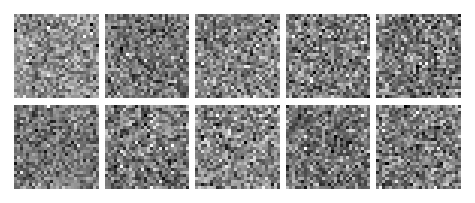

In [27]:
# nothing, not trained at all
W0 = np.random.randn(DIGIT_SIZE*DIGIT_SIZE + 1, 10)

fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W0)

We can now fit multinomial logistic regression model to the MNIST dataset. Initially we do 200 gradient descent steps starting from `W0`.

In [29]:
# cost value jumps at the end because we're making too big steps
# how to fix it? reduce learning rate !
W = gd_fit(W0,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=3.0, steps=200, log_every=10)

Step   1	cost value: 12.78,	train accuracy: 21.97,	validation accuracy: 22.97
Step  10	cost value:  3.20,	train accuracy: 66.64,	validation accuracy: 67.39
Step  20	cost value:  1.56,	train accuracy: 75.44,	validation accuracy: 76.42
Step  30	cost value:  1.15,	train accuracy: 79.63,	validation accuracy: 80.59
Step  40	cost value:  1.00,	train accuracy: 81.47,	validation accuracy: 82.22
Step  50	cost value:  0.91,	train accuracy: 82.45,	validation accuracy: 83.32
Step  60	cost value:  0.85,	train accuracy: 83.20,	validation accuracy: 84.02
Step  70	cost value:  0.81,	train accuracy: 83.87,	validation accuracy: 84.50
Step  80	cost value:  0.76,	train accuracy: 84.56,	validation accuracy: 85.23
Step  90	cost value:  0.71,	train accuracy: 85.22,	validation accuracy: 85.68
Step 100	cost value:  0.68,	train accuracy: 85.65,	validation accuracy: 86.09
Step 110	cost value:  0.67,	train accuracy: 85.57,	validation accuracy: 85.97
Step 120	cost value:  0.68,	train accuracy: 85.30,	validation ac

Next, we continue with additional 300 steps using a lower learning rate.

In [30]:
# notes
# overfeeding validation data
# train accuracy goes up still but validation doesnt change much -> the difference between the accuracies is becoming bigger 
# actually it's whole percent in situation below!
# cost value doesn't jump like that anymore, becomes stable
W = gd_fit(W,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=0.3, steps=300, log_every=25)

Step   1	cost value:  0.50,	train accuracy: 89.09,	validation accuracy: 88.41
Step  25	cost value:  0.49,	train accuracy: 89.11,	validation accuracy: 88.43
Step  50	cost value:  0.49,	train accuracy: 89.08,	validation accuracy: 88.43
Step  75	cost value:  0.49,	train accuracy: 89.11,	validation accuracy: 88.45
Step 100	cost value:  0.49,	train accuracy: 89.18,	validation accuracy: 88.45
Step 125	cost value:  0.48,	train accuracy: 89.20,	validation accuracy: 88.50
Step 150	cost value:  0.48,	train accuracy: 89.22,	validation accuracy: 88.46
Step 175	cost value:  0.48,	train accuracy: 89.24,	validation accuracy: 88.45
Step 200	cost value:  0.48,	train accuracy: 89.25,	validation accuracy: 88.44
Step 225	cost value:  0.47,	train accuracy: 89.28,	validation accuracy: 88.43
Step 250	cost value:  0.47,	train accuracy: 89.30,	validation accuracy: 88.43
Step 275	cost value:  0.47,	train accuracy: 89.34,	validation accuracy: 88.43
Step 300	cost value:  0.47,	train accuracy: 89.37,	validation ac

Let's plot the fitted parameters.

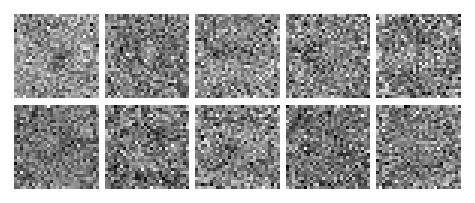

In [36]:
# cost function is convex but not strongly convex -> sheet of paper example
# how to solve it (make stronly too) ? -> regularization term
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W)

## Fitting regularized multinomial logistic regression model to MNIST.

Cross entropy cost function is convex but it is <u>not</u> strictly convex. We can turn it into a strictly convex cost function by adding a regularization term that penalizes magnitudes of model parameters:

$$ \large
\mathcal{L}_R\left(\mathbf{W}\right) = \mathcal{L}\left(\mathbf{W}\right) +
                                       \frac{\lambda}{2}\sum_{i=1}^{d+1}\sum_{j=1}^k w_{ij}^2,
$$

where $\mathcal{L}\left(\mathbf{W}\right)$ is the cross entropy cost.

This is the same regularization that we used in ridge regression, and it can be derived as a MAP estimate in a Bayesian logistic regression model with Gaussian prior on model parameters (we do not need a conjugate prior to find the cost function for a MAP estimate). Let's implement this variant of the logistic regression model.

Complete the implementation of `gd_fit_reg` function following comments in the code.

In [39]:
def gd_fit_reg(W0, X, T, X_val, T_val, l2=0.005, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        l2:        The regularization strength (\lambda hyper-paramater).
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the regularized cost function and store it in `cost_val` variable.
        
        # now we must take care of regularization term as well
        
        Z = X @ W
        S = softmax(Z)
        cost_val = xentropy(S,T) + l2 / 2 * np.sum(W*W) # <- right here
        
        # Next, calculate the gradient of the regularized cost function w.r.t the
        # parameters in `W`. Use this gradient matrix to update `W` (according to
        # the gradient descent update rule).
        
        # same thing here, gradient of the regularization term turns out to be very simple
        
        G = grad_xentropy(X,S,T)
        R_G = l2 * W
        W = W - lr * (G + R_G)
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

Let's fit regularized multinomial logistic regression model to the MNIST dataset.

In [45]:
# after adding regularization term cost value seems to go down more slowly
# also accuracies tend to go up more slowly as well
# let's make it better my lowering learning rate as we did before
W_reg = gd_fit_reg(W0,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=3.0,
                   steps=200, log_every=10)

Step   1	cost value: 32.65,	train accuracy: 21.96,	validation accuracy: 23.03
Step  10	cost value: 18.08,	train accuracy: 66.61,	validation accuracy: 66.85
Step  20	cost value: 12.75,	train accuracy: 71.48,	validation accuracy: 71.50
Step  30	cost value:  9.63,	train accuracy: 74.52,	validation accuracy: 74.23
Step  40	cost value:  7.21,	train accuracy: 77.98,	validation accuracy: 78.10
Step  50	cost value:  6.87,	train accuracy: 77.69,	validation accuracy: 78.59
Step  60	cost value:  5.00,	train accuracy: 62.78,	validation accuracy: 62.33
Step  70	cost value:  3.73,	train accuracy: 79.14,	validation accuracy: 79.42
Step  80	cost value:  3.16,	train accuracy: 75.92,	validation accuracy: 75.82
Step  90	cost value:  2.62,	train accuracy: 77.93,	validation accuracy: 78.01
Step 100	cost value:  2.67,	train accuracy: 70.73,	validation accuracy: 70.59
Step 110	cost value:  1.97,	train accuracy: 76.15,	validation accuracy: 76.85
Step 120	cost value:  2.65,	train accuracy: 70.03,	validation ac

In [46]:
# yay! seems like it did the job
# cost value is close to the values when we didnt' use regularization term
# However, accuracy went up significantly and values of train and validation accuracy is pretty close
# Note that last time it was nearly 1% !
W_reg = gd_fit_reg(W_reg,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=0.3,
                   steps=300, log_every=25)

Step   1	cost value:  1.61,	train accuracy: 78.98,	validation accuracy: 79.88
Step  25	cost value:  0.77,	train accuracy: 89.69,	validation accuracy: 90.38
Step  50	cost value:  0.72,	train accuracy: 89.91,	validation accuracy: 90.43
Step  75	cost value:  0.68,	train accuracy: 90.23,	validation accuracy: 90.62
Step 100	cost value:  0.64,	train accuracy: 90.44,	validation accuracy: 90.77
Step 125	cost value:  0.61,	train accuracy: 90.61,	validation accuracy: 90.84
Step 150	cost value:  0.58,	train accuracy: 90.69,	validation accuracy: 90.94
Step 175	cost value:  0.56,	train accuracy: 90.89,	validation accuracy: 91.05
Step 200	cost value:  0.54,	train accuracy: 91.06,	validation accuracy: 91.01
Step 225	cost value:  0.53,	train accuracy: 91.14,	validation accuracy: 91.04
Step 250	cost value:  0.52,	train accuracy: 91.23,	validation accuracy: 91.12
Step 275	cost value:  0.51,	train accuracy: 91.26,	validation accuracy: 91.23
Step 300	cost value:  0.50,	train accuracy: 91.32,	validation ac

Finally we plot the parameters of the regularized model.

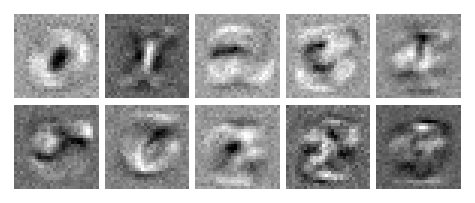

In [42]:
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W_reg)

Seems like we finally get some reasonable results. The parameters tend to look like appropriate digits.  
Those which are always written in simple, similar way tend to look like it's real equivalents.  
However, those which are written differently e.g. 1 tend to look odd. It's because it's often written at different angles and it ends up looking like X (doesn't know which side to choose).  
Some digits doesn't really look like them at all e.g. 4. The reason behind that is similar.